# Reproducing the Single-Hidden-Layer NN from Ch.10 in ISLR2 with Pytorch

#### In the 2nd edition of [An Introduction to Statistical Learning](https://www.statlearning.com/), Deep Learning is introduced in Chapter 10. 
#### Using the [Hitters dataset](https://www.statlearning.com/resources-second-edition), the goal is to predict the Salary of a baseball player in 1987 using his performance statistics from 1986. The dataset consisists 263 players and 19 variables. We randomly split the data into a training set of 176 players (two thirds), and a test set of 87 players (one third). 

## Basic approach with Multiple Linear Regression (20 parameters)

In [361]:
import pandas as pd
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [362]:
Hitters = pd.read_csv('data/Hitters.csv', header=0, na_values='NA')

# drop rows NA values and reindex
Hitters = Hitters.dropna().reset_index(drop=True) 
print(Hitters.shape)
Hitters.head()

(263, 20)


,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,League,Division,PutOuts,Assists,Errors,Salary,NewLeague
0,315,81,7,24,38,39,14,3449,835,69,321,414,375,N,W,632,43,10,475.0,N
1,479,130,18,66,72,76,3,1624,457,63,224,266,263,A,W,880,82,14,480.0,A
2,496,141,20,65,78,37,11,5628,1575,225,828,838,354,N,E,200,11,3,500.0,N
3,321,87,10,39,42,30,2,396,101,12,48,46,33,N,E,805,40,4,91.5,N
4,594,169,4,74,51,35,11,4408,1133,19,501,336,194,A,W,282,421,25,750.0,A


In [363]:
# convert categorical to dummy variables
y = Hitters.Salary
dummies = pd.get_dummies(Hitters[['League', 'Division', 'NewLeague']])

# drop response and categorical variables
X_prep = Hitters.drop(['Salary', 'League', 'Division', 'NewLeague'], axis = 1).astype('float64')
X = pd.concat([X_prep,  dummies[['League_A', 'Division_E', 'NewLeague_A']]], axis=1)
print(X.shape)
X.head()

(263, 19)


,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,PutOuts,Assists,Errors,League_A,Division_E,NewLeague_A
0,315.0,81.0,7.0,24.0,38.0,39.0,14.0,3449.0,835.0,69.0,321.0,414.0,375.0,632.0,43.0,10.0,0,0,0
1,479.0,130.0,18.0,66.0,72.0,76.0,3.0,1624.0,457.0,63.0,224.0,266.0,263.0,880.0,82.0,14.0,1,0,1
2,496.0,141.0,20.0,65.0,78.0,37.0,11.0,5628.0,1575.0,225.0,828.0,838.0,354.0,200.0,11.0,3.0,0,1,0
3,321.0,87.0,10.0,39.0,42.0,30.0,2.0,396.0,101.0,12.0,48.0,46.0,33.0,805.0,40.0,4.0,0,1,0
4,594.0,169.0,4.0,74.0,51.0,35.0,11.0,4408.0,1133.0,19.0,501.0,336.0,194.0,282.0,421.0,25.0,1,0,1


In [364]:
# scale so that each feature has mean zero and variance one
scaler = StandardScaler()
X[X.columns] = scaler.fit_transform(X[X.columns])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, shuffle=False)

In [365]:
LR = LinearRegression()
LR.fit(X_train, y_train)
y_pred = LR.predict(X_test)
model_skill = mean_absolute_error(y_test, y_pred)
print(f"mean absolute error: {model_skill}")

mean absolute error: 256.891370562953


## Deep Learning approach with Pytorch 
### 1051 Parameters (weights = $50 \times 19 + 50 \times 1$; bias = $50 + 1$)

In [366]:
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
torch.manual_seed(13)
import numpy as np
import matplotlib.pyplot as plt

In [367]:
DROPOUT = 0.4
BATCH_SIZE = 32
LEARNING_RATE = 0.01
RELU_UNITS = 50
EPOCHS = 1500

X_train_tensor = torch.tensor(X_train.values.astype(np.float32))
y_train_tensor = torch.tensor(y_train.values.astype(np.float32))
dataset = TensorDataset(X_train_tensor, y_train_tensor)
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

In [368]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cpu device


### Define Model Architecture 

In [369]:
class LR(nn.Module):
    def __init__(self):
        super(LR, self).__init__()
        self.hidden = nn.Linear(in_features=X_train.shape[1], out_features=RELU_UNITS)
        self.activation = nn.ReLU()
        self.dropout = nn.Dropout(DROPOUT)
        self.output = nn.Linear(RELU_UNITS, 1)
        

    def forward(self, x):
        x = self.hidden(x)
        x = self.activation(x)
        x = self.dropout(x)
        x = self.output(x)
        return x


In [370]:
model = LR().to(device)
print(model)
total_parameters = sum(p.numel() for p in model.parameters())
print (f"model parameters: {total_parameters}")

LR(
  (hidden): Linear(in_features=19, out_features=50, bias=True)
  (activation): ReLU()
  (dropout): Dropout(p=0.4, inplace=False)
  (output): Linear(in_features=50, out_features=1, bias=True)
)
model parameters: 1051


### Train Model

In [371]:
criterion = torch.nn.MSELoss() 
optimizer = torch.optim.RMSprop(model.parameters(), lr=LEARNING_RATE)

In [372]:
size = len(dataloader.dataset)
loss_all = []

for epoch in range(EPOCHS):
    # print(f"-------------\nEpoch {epoch + 1}")
    # Loop over batches in an epoch using DataLoader
    current = 0
    for batch, (x_batch, y_batch) in enumerate(dataloader):
        
        # compute prediction error
        y_batch_pred = model(x_batch)
        loss = criterion(y_batch_pred, y_batch.view(-1, 1))

        # backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if batch % 2 == 0:
            loss = loss.item()
            current = (batch+1) * len(x_batch)
            # print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
            
    loss_all.append(loss.item())

### Plot Training Loss

Text(0, 0.5, 'Loss [MSE]')

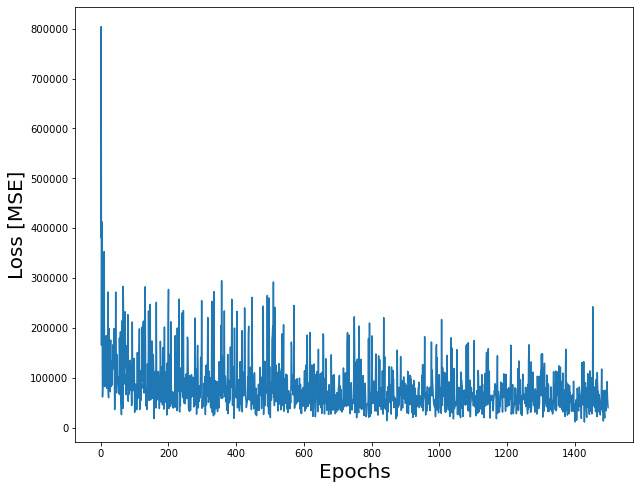

In [373]:
plt.figure(figsize=(10, 8))
plt.plot(loss_all)
plt.xlabel('Epochs', fontsize=20)
plt.ylabel('Loss [MSE]', fontsize=20)

### Skill on test set

In [374]:
mae = nn.L1Loss()
y_test_tensor = torch.tensor(y_test.values).view(-1, 1)
y_pred_tensor = model(torch.tensor(X_test.values.astype(np.float32)))
model_skill = mae(y_test_tensor, y_pred_tensor).detach().numpy()
print(f"mean absolute error: {model_skill}")

mean absolute error: 266.55677286783856


In [375]:
y_pred_tensor

tensor([[ 874.9491],
        [ 354.4938],
        [ 120.1088],
        [ 322.7629],
        [ 271.0838],
        [ 539.0363],
        [ 904.0508],
        [ 468.7598],
        [1300.2028],
        [ 372.5010],
        [ 346.5380],
        [ 318.7721],
        [1138.5032],
        [ 131.1846],
        [ 723.8254],
        [ 638.3289],
        [ 343.5515],
        [ 211.5504],
        [ 347.3004],
        [ 731.3546],
        [ 328.2726],
        [ 530.9124],
        [ 521.7997],
        [ 555.2650],
        [2017.9623],
        [ 281.3889],
        [ 673.4678],
        [ 235.2381],
        [ 215.6898],
        [ 168.7092],
        [ 760.5189],
        [ 193.3846],
        [ 544.8069],
        [ 516.7919],
        [ 234.7217],
        [ 931.1333],
        [ 969.8396],
        [ 473.5273],
        [  84.8646],
        [ 491.3084],
        [ 299.9960],
        [ 240.5740],
        [1251.2529],
        [ 424.7430],
        [ 105.4954],
        [1048.6951],
        [ 185.6479],
        [ 490

In [376]:
def ReLU(x):
    return x * (x > 0)

inputs = X_test.values.astype(np.float32)[-1] # (19)
hidden_weights = [p for p in model.parameters()][0].detach().numpy() # (50, 19)
hidden_biases = [p for p in model.parameters()][1].detach().numpy() # (50,)

inputs_hidden_layer = np.array([ReLU(i) for i in ((inputs * hidden_weights).sum(axis=1)+hidden_biases)])
inputs_hidden_layer

array([ 3.3487625 , -0.        ,  9.228004  ,  2.68788   , -0.        ,
        0.85455084,  1.5597413 ,  4.590785  ,  6.031643  , 11.892583  ,
        3.4782596 , -0.        , 11.323209  , 14.172894  , -0.        ,
        3.126887  , 13.492205  ,  4.073326  ,  1.8152077 ,  3.4959562 ,
        6.1139097 ,  7.2880096 , -0.        , -0.        ,  7.014283  ,
       -0.        ,  2.6003711 , -0.        , -0.        , 13.202897  ,
       -0.        , -0.        ,  3.552662  ,  6.2387023 ,  0.9649739 ,
       -0.        , -0.        ,  6.558054  ,  6.6423345 ,  1.16154   ,
        0.02023983,  3.930396  ,  6.070021  , -0.        , -0.        ,
        8.989567  ,  4.37005   ,  5.0030956 ,  3.8862314 ,  3.9699833 ],
      dtype=float32)

In [377]:
output_weights = [p for p in model.parameters()][2].detach().numpy()
output_bias = [p for p in model.parameters()][3].detach().numpy()[0]
(output_weights * inputs_hidden_layer)[0].sum() + output_bias

660.04

In [378]:
inputs

array([ 1.5463662 ,  1.3803698 , -0.29972985,  0.8730362 , -0.289806  ,
       -0.4665865 ,  0.77086794,  0.9860771 ,  1.1357838 , -0.47829092,
        1.2517215 ,  0.08235959, -0.04274716,  0.41978592, -0.79252   ,
       -0.8482187 ,  0.94450325, -0.98116595,  0.9301872 ], dtype=float32)

In [381]:
hidden_weights

array([[-1.41062605e+00,  3.57335830e+00,  7.84062922e-01,
        -1.68193519e+00, -6.97153389e-01,  2.20781684e+00,
         2.99687564e-01, -2.74830699e+00,  7.87954748e-01,
         1.85342729e+00, -2.60141641e-01,  2.62475538e+00,
        -1.28750682e+00,  5.13300061e-01, -1.10516262e+00,
         3.36067200e-01, -2.62715054e+00, -2.04650998e+00,
         2.81351876e+00],
       [-2.77110672e+00,  5.49165821e+00, -4.86822456e-01,
        -2.12548995e+00,  5.47750294e-03,  3.57671070e+00,
        -6.39160156e-01, -2.14713740e+00,  2.35872746e+00,
         4.54526424e-01, -3.94347280e-01,  3.78051949e+00,
        -1.85211182e+00,  6.00748062e-01,  1.37247026e+00,
         3.07788134e-01,  1.09675801e+00,  9.76185799e-01,
        -1.37648678e+00],
       [-6.84411407e-01,  1.97375953e+00,  5.12054503e-01,
        -9.81427908e-01, -3.09495878e+00, -1.21700025e+00,
        -1.10417533e+00, -8.76173735e-01,  1.90700924e+00,
        -8.84274304e-01,  4.49721527e+00, -1.01934636e+00,
    

In [382]:
inputs * hidden_weights

array([[-2.18134451e+00,  4.93255568e+00, -2.35007063e-01,
        -1.46839035e+00,  2.02039242e-01, -1.03013754e+00,
         2.31019542e-01, -2.71004248e+00,  8.94946218e-01,
        -8.86477411e-01, -3.25624883e-01,  2.16173783e-01,
         5.50372638e-02,  2.15476140e-01,  8.75863492e-01,
        -2.85058469e-01, -2.48135233e+00,  2.00796580e+00,
         2.61709929e+00],
       [-4.28514576e+00,  7.58051920e+00,  1.45915225e-01,
        -1.85562968e+00, -1.58741325e-03, -1.66884494e+00,
        -4.92708087e-01, -2.11724305e+00,  2.67900443e+00,
        -2.17395857e-01, -4.93612975e-01,  3.11362028e-01,
         7.91725218e-02,  2.52185583e-01, -1.08771014e+00,
        -2.61071652e-01,  1.03589153e+00, -9.57800269e-01,
        -1.28039038e+00],
       [-1.05835068e+00,  2.72451806e+00, -1.53478026e-01,
        -8.56822073e-01,  8.96937668e-01,  5.67835867e-01,
        -8.51173341e-01, -8.63974810e-01,  2.16595030e+00,
         4.22940373e-01,  5.62926102e+00, -8.39529485e-02,
    